In [1]:
# !pip install tensorflow
# !pip install rasterio
# !pip install torch
# !pip install torchvision

In [11]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno

import cv2
import random
from scipy.ndimage.filters import median_filter

from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path

import tensorflow as tf

from sklearn.metrics import r2_score

import os
import warnings
warnings.filterwarnings('ignore')

import rasterio

import torch
import torchvision.transforms.functional as TF

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

Let's try working on the png files first.

In [12]:
# opening the merge file

df = pd.read_csv('df.csv', index_col=0)
df.head(3)

,source_id,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,source_type,confidence_in_persistence,candidate_id,...,ipcc,qplume,sigma_qplume,satellite,timestamp,flight_path,time,datetime,filepath,filename_png_all
2185,P00001,32.212086,-103.69721,12,0.833333,865.48423,307.380288,tank,high,ang20191019t163936-1,...,Oil & Natural Gas,1155.77257,212.605003,ang,20191019t16393,ang-1,04:33:13,2019-10-19 04:33:13,C:\Users\Owner\Desktop\methane_enemy\data\imag...,ang20191019t163936-1_r1070_c236-plume.png
2186,P00001,32.212086,-103.69721,12,0.833333,865.48423,307.380288,tank,high,ang20191019t155740-1,...,Oil & Natural Gas,1094.33953,278.602960,ang,20191019t15574,ang-1,04:19:34,2019-10-19 04:19:34,C:\Users\Owner\Desktop\methane_enemy\data\imag...,ang20191019t155740-1_r1286_c317-plume.png
2187,P00001,32.212086,-103.69721,12,0.833333,865.48423,307.380288,tank,high,ang20190922t192642-2,...,Oil & Natural Gas,2579.52810,902.732655,ang,20190922t19264,ang-2,05:21:04,2019-09-22 05:21:04,C:\Users\Owner\Desktop\methane_enemy\data\imag...,ang20190922t192642-2_r4578_c217-plume.png


Now that we mapped all filenames according to its qplume value, let's try to make a model. But first prepare the final dataset first.

In [13]:
images = df

# Let's try modeling what we have. 

In [14]:
# Let's only use 1000 images to speed up training time
# image_df = images.sample(1000, random_state=1).reset_index(drop=True)

# It's not a long wait, let's try modeling what we have. 
image_df = images

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Loading the images

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [16]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='qplume',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='qplume',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='qplume',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 1692 validated image filenames.
Found 422 validated image filenames.
Found 907 validated image filenames.


In [17]:
# train_images = train_generator.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='filepath',
#     y_col='ipcc',
#     target_size=(120, 120),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=42,
#     subset='training'
# )

# val_images = train_generator.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='filepath',
#     y_col='ipcc',
#     target_size=(120, 120),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=42,
#     subset='validation'
# )

# test_images = test_generator.flow_from_dataframe(
#     dataframe=test_df,
#     x_col='filepath',
#     y_col='ipcc',
#     target_size=(120, 120),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=False
# )

# Training

In [18]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
53/53 [==============================] - 24s 409ms/step - loss: 998184.8750 - val_loss: 574159.3125
Epoch 2/100
53/53 [==============================] - 19s 351ms/step - loss: 719165.0625 - val_loss: 386255.2500
Epoch 3/100
53/53 [==============================] - 17s 329ms/step - loss: 675183.1875 - val_loss: 386954.8438
Epoch 4/100
53/53 [==============================] - 16s 300ms/step - loss: 673878.3750 - val_loss: 387108.6562
Epoch 5/100
53/53 [==============================] - 17s 316ms/step - loss: 670186.5625 - val_loss: 395634.6562
Epoch 6/100
53/53 [==============================] - 16s 303ms/step - loss: 671808.4375 - val_loss: 383854.0312
Epoch 7/100
53/53 [==============================] - 18s 333ms/step - loss: 668516.4375 - val_loss: 383048.7188
Epoch 8/100
53/53 [==============================] - 18s 333ms/step - loss: 678308.3750 - val_loss: 396885.5312
Epoch 9/100
53/53 [==============================] - 18s 333ms/step - loss: 666982.5000 - val_loss: 3813

In [19]:
# from tensorflow.keras import layers

# # Define the model architecture
# model = tf.keras.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(6, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Fit the model to the training data
# history = model.fit(train_images, epochs=10, validation_data=val_images)

# Results

In [20]:
predicted_qplume = np.squeeze(model.predict(test_images))
true_qplume = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_qplume, predicted_qplume)
print("Test R^2 Score: {:.5f}".format(r2))

29/29 [==============================] - 9s 294ms/step
Test RMSE: 689.65408
Test R^2 Score: 0.16588


In [10]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images)

# Print the test loss and test accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

29/29 [==============================] - 7s 227ms/step - loss: 2.2374e-05


TypeError: cannot unpack non-iterable float object

In [173]:
# import pickle

# # save the model to a pickle file
# with open('model.pkl', 'wb') as f:
#     pickle.dump(history, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\global_average_pooling2d
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-21 23:11:40         4204
metadata.json      

In [2]:
# import pickle

# # Load the saved model
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)


Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-21 23:11:40         4204
metadata.json                                  2023-02-21 23:11:40           64
variables.h5                                   2023-02-21 23:11:40       173672
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\global_average_pooling2d
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
..

In [24]:
# Define the input image dimensions
img_width, img_height = 120, 120

# Load and preprocess the input images
def preprocess_image(filename):
    img = Image.open(filename)
    img = img.resize((img_width, img_height))
    img = img.convert('RGB')  # convert the image to RGB mode
    img = np.array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # add an extra dimension to the array
    return img

# Define the directory containing the input images
directory = 'C:/Users/Owner/Desktop/methane_enemy/test_set/testfiles2'

# Iterate over the image files in the directory
X = []
ids = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        img = preprocess_image(img_path)
        X.append(img)
        ids.append(filename[:-4])  # Remove the file extension from the ID

X = np.concatenate(X, axis=0)  # concatenate the input images into a single array

# Use the model to make predictions
y_pred = model.predict(X)

# Combine the IDs and predicted values into a DataFrame
results_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})


1/1 [==============================] - 0s 155ms/step


In [27]:
results_df['id'] = results_df['id'] + '.png'

In [28]:
results_df

,id,prediction
0,01A.png,1303.807007
1,02A.png,877.327209
2,03A.png,481.646759
3,04A.png,387.597534
4,05A.png,387.178284
5,06A.png,458.719818
6,07A.png,399.808868
7,08A.png,463.695465
8,09A.png,1806.716064
9,10A.png,1237.530396


In [29]:
results_df.to_csv('kaggle_submission_bvc_data_warriors.csv')

# Let's feature engineer and see what more we can fine tune. 

See if we can mask raster image to background.   

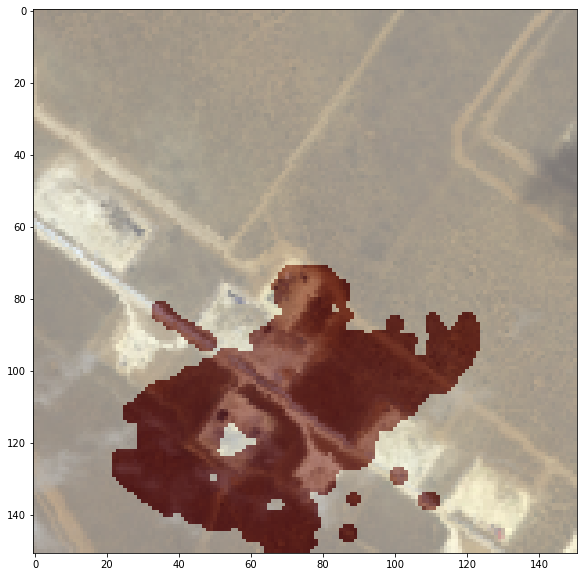

In [1]:
# Load the RGB TIFF image and the raster file
rgb_file = 'ang20190922t192642_ang20190922t192642-2_r4578_c217_rgb.tif'
plume_file = 'ang20190922t192642_ang20190922t192642-2_r4578_c217_ctr.tif'

with rasterio.open(rgb_file) as src:
    rgb_data = src.read()

with rasterio.open(plume_file) as src:
    plume_data = src.read(1)

# Normalize the RGB image
rgb_norm = np.zeros_like(rgb_data, dtype=np.float32)
for i in range(3):
    rgb_norm[i] = (rgb_data[i] - np.min(rgb_data[i])) / (np.max(rgb_data[i]) - np.min(rgb_data[i]))

# Subtract the background from the plume data
background = np.mean(rgb_norm, axis=0)
plume_data = plume_data - background

# Apply a median filter to remove noise
plume_data = median_filter(plume_data, size=3)

# Apply a threshold to segment the plume
thresh = 0.5
plume_mask = plume_data > thresh

# Display the plume mask over the RGB background image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm.transpose([1, 2, 0]))
plt.imshow(plume_mask, cmap='Reds', alpha=0.5)
plt.show()


#### Notes:

1. Regression in remote sensing involves predicting continuous variables such as wind speed, tree height, or soil moisture from an image. Both classical machine learning and deep learning approaches can be used to accomplish this task. Classical machine learning utilizes feature engineering to extract numerical values from the input data, which are then used as input for a regression algorithm like linear regression. On the other hand, deep learning typically employs a convolutional neural network (CNN) to process the image data, followed by a fully connected neural network (FCNN) for regression. The FCNN is trained to map the input image to the desired output, providing predictions for the continuous variables of interest.

https://github.com/satellite-image-deep-learning/techniques 

2. More EDA: See direction of the wind. Height of the plume and correlation to the sigma. Wind direction in the area and permian. see patterns for the sigma and images. 